# Probabilistic Programming for Music Research

This notebook shows a case study of how to use Bayesian models and probabilistic programming to make inferences about musical data and corpora.
We will focus on the python library [PyMC](https://www.pymc.io/welcome.html), but also show some examples in [pyro](http://pyro.ai/) and [numpyro](https://num.pyro.ai/en/stable/).

The case study deals with a toy example: modeling the sizes of melodic intervals in Bach chorales.
You will see how to express different assumptions about how these intervals work in probabilistic models,
how to apply these models to a dataset to make inferences,
and how to compare and evaluate the different models.

In [1]:
# data
import pandas as pd
import numpy as np

# PyMC (good for MCMC inference)
import pymc as pm
import pytensor as ptn

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import arviz as az

In [2]:
# setup
%config InlineBackend.figure_format = "retina"
rng = np.random.default_rng(14842)

# Data

Here we just load the dataset that we will work with.
It contains a list so-called "bigrams" - pairs of sequential notes - from each voice of the first 100 chorales in the 371 Bach chorales collection.
Thus, for each bigram we know the pitch of the first note (in MIDI as well as tpc (= line-of-fifths position) + octave),
the pitch of the second note, the voice (staff) and piece in which it appears,
as well as some derived information such as the interval in semitones and the absolute size of the interval in semitones.

In [3]:
dists = pd.read_csv("bigrams.tsv", sep="\t", index_col=["piece", "staff", "bigram_id"])
dists

n0_tpc  n0_octave  n1_tpc  n1_octave  n0_midi  \
piece   staff bigram_id                                                  
chor001 1     0               1          4       1          4       67   
              1               1          4       2          5       67   
              2               2          5       5          4       74   
              3               5          4       3          4       71   
              4               3          4       1          4       69   
...                         ...        ...     ...        ...      ...   
chor100 4     56              2          3      -3          3       50   
              57             -3          3       2          3       51   
              58              2          3       0          3       50   
              59              0          3       2          3       48   
              60              2          3       1          2       50   

                         int_fifths  int_octaves  int_semitones  \
piece   staff bigram_id                                           
chor001 1     0                   0            0              0   
              1                   1            0              7   
              2                   3           -2             -3   
              3                  -2            1             -2   
              4                  -2            1             -2   
...                             ...          ...            ...   
chor100 4     56                 -5            3              1   
              57                  5           -3             -1   
              58                 -2            1             -2   
              59                  2           -1              2   
              60                 -1            0             -7   

                         dist_semitones  
piece   staff bigram_id                  
chor001 1     0                       0  
              1                       7  
              2                       3  
              3                       2  
              4                       2  
...                                 ...  
chor100 4     56                      1  
              57                      1  
              58                      2  
              59                      2  
              60                      7  

[22018 rows x 9 columns]

Let's have a look at the distribution of the (directed) intervals in each voice.
We can see that they are usually centered around 0 (unison) and roughly symmetric.
Smaller intervals are more frequent than larger intervals.
The distribution looks similar in the different voices, but not exactly the same.

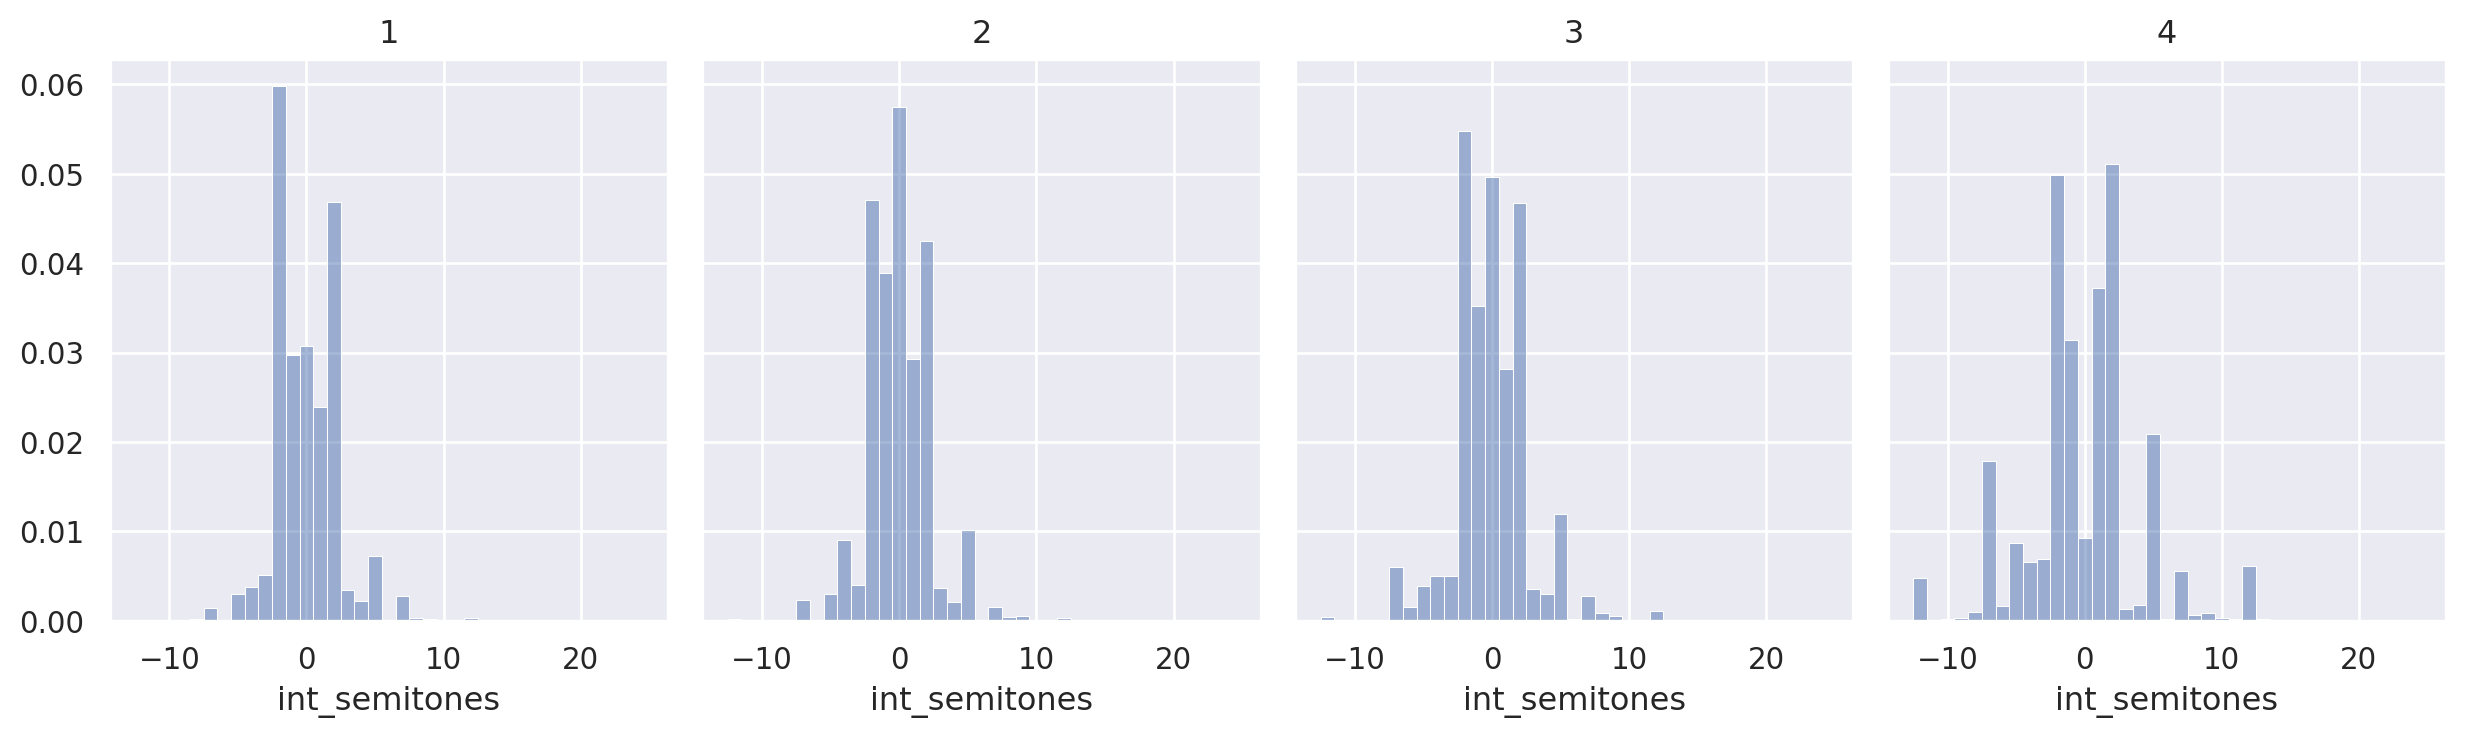

In [4]:
(
    so.Plot(dists, x="int_semitones")
        .facet("staff")
        .add(so.Bars(alpha=0.5), so.Hist("probability", discrete=True))
        #.add(so.Line(), so.KDE())
        .layout(size=(13,4))
)

Here is the same plot for the absolute distances.

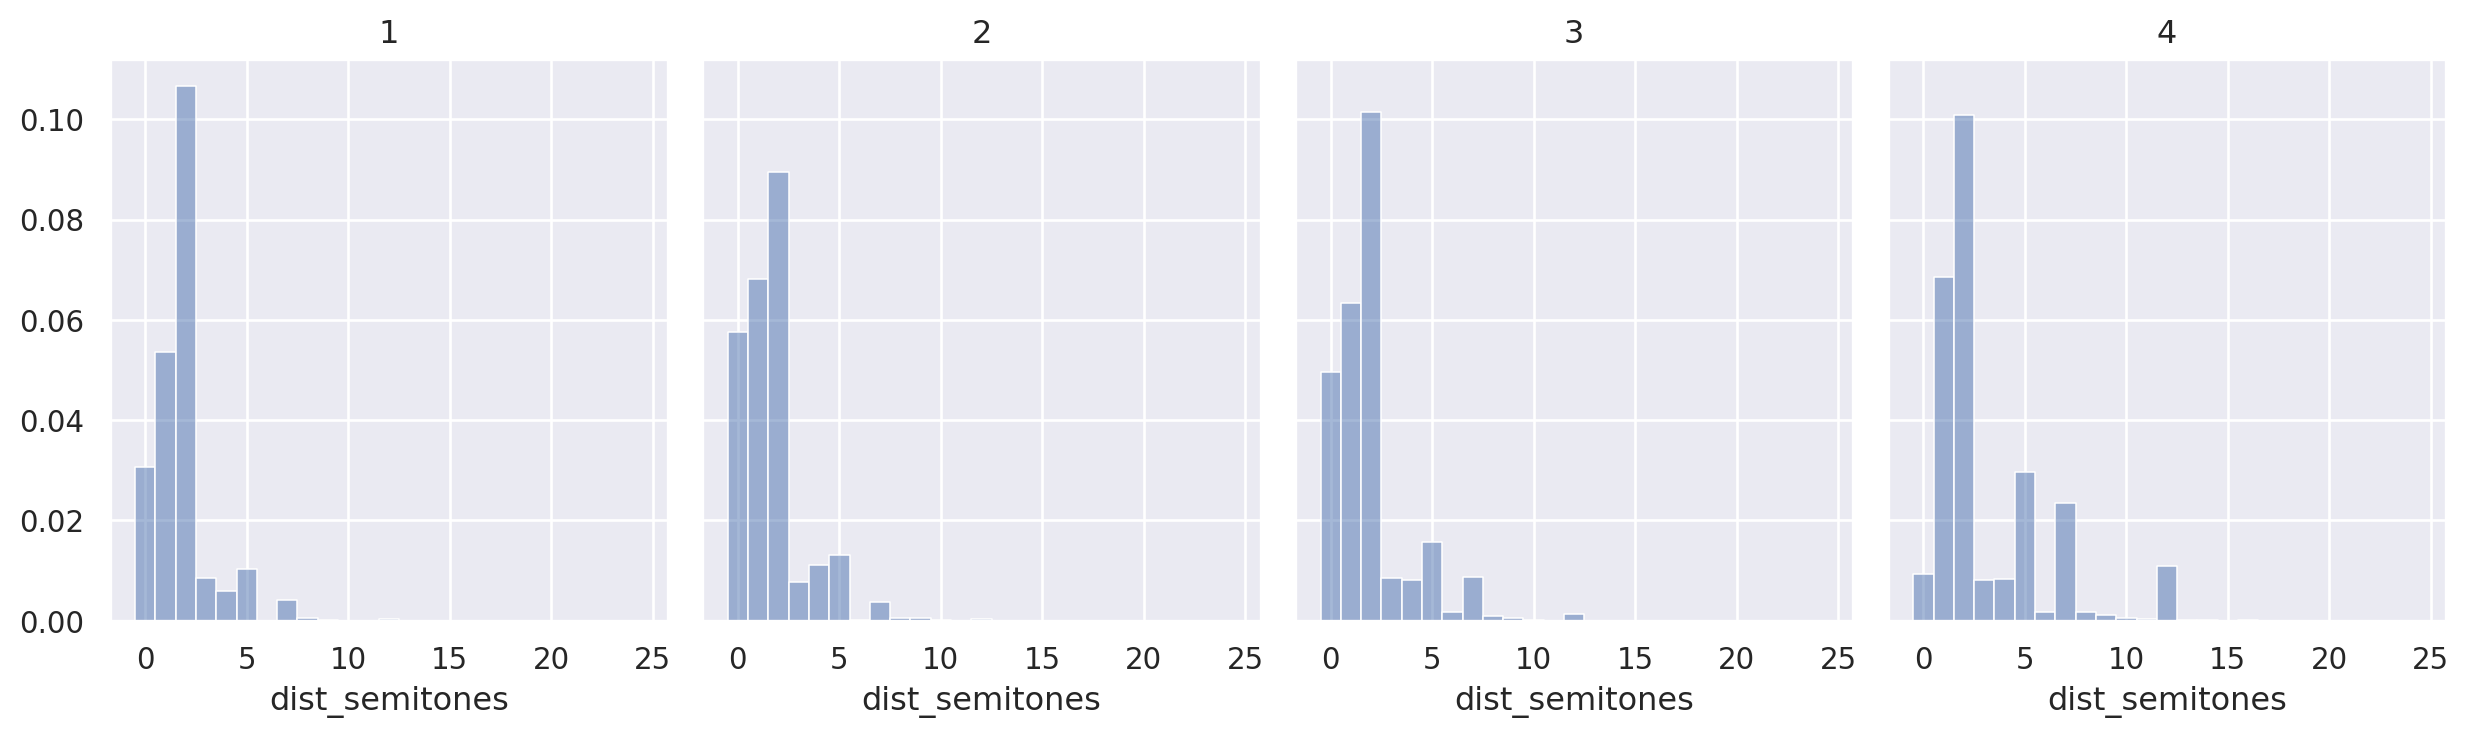

In [5]:
(
    so.Plot(dists, x="dist_semitones")
        .facet("staff")
        .add(so.Bars(alpha=0.5), so.Hist("probability", discrete=True))
        #.add(so.Line(), so.KDE())
        .layout(size=(13,4))
)

Let's now extract some of this data that we will use for modelling:
- the observed absolute intervals or "distances"; this is what we want to understand
- the staff in which a bigram appears
- the pitch (MIDI) of the first note in each bigram

The latter two might have an influence on the intervals that we observe,
and this relationship is what we are going to model and make inferences about.

In [6]:
observations = np.array(dists["dist_semitones"].to_numpy())
observations

array([0, 7, 3, ..., 2, 2, 7])

In [7]:
voice = dists.index.get_level_values("staff").to_numpy()-1
voice

array([0, 0, 0, ..., 3, 3, 3])

In [8]:
p0 = dists["n0_midi"].to_numpy()
p0

array([67, 67, 74, ..., 50, 48, 50])

In [9]:
# a helper function for later
def estimate_beta(samples):
    mean = samples.mean(dim=["chain", "draw"]).to_numpy()
    var = samples.var(dim=["chain", "draw"]).to_numpy()
    common = (mean * (1-mean) / var) - 1
    alpha = common * mean
    beta = common * (1-mean)
    return alpha, beta

# Model 1: one global spread parameter

Our first model is very simple: we just assume the observed intervals to be random.
But "random" doesn't mean "completely arbitrary",
we still assume that they follow a certain distribution.
If we look at the shape of the data in the plots above, we can see that
very large intervals are possible but small steps or unisons are most likely.
Thus, we pick a [geometric distribution](https://en.wikipedia.org/wiki/Geometric_distribution),
which works as follows:
You flip a coin (with a certain probability $\theta$) until it shows *heads* for the first time.
You then count the number of trials.
This is a bit like taking a number of steps (here: steps away from the previous note),
but at each step you flip a coin to determine if you want to keep walking or stay where you are.
So it's not an entirely unreasonable model for musical intervals,
we just try to decide how far we want to go away from the previous note.

If we write this (very simplistic) view on how melodic intervals work
and try to express it as a generative model, it looks something like this:
- Choose a $\theta$ between 0 and 1
- For each $i$ between $0$ and $N$:
  - Choose $x_i$ from a geometric distribution with parameter $\theta$.

Since our model needs a prior distribution for $\theta$,
we will choose a [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution).
The reason for this is that the beta distribution is a so-called "conjugate prior" to the geometric distribution.
That means: if the prior $p(\theta)$ is beta-distributed and it is used in a geometric distribution ($p(x|\theta)$),
then the posterior $p(\theta|x)$ will again be a beta distribution!
In particular, we choose the distribution $Beta(0.5, 0.5)$, which is the so-called [Jeffreys prior](https://en.wikipedia.org/wiki/Jeffreys_prior), an uninformative prior.
(In our case, we have so much data that the choice of the prior doesn't really make a big difference for $\theta$,
so we could also pick $Beta(1,1)$, which is actually a uniform distribution between 0 and 1).

If we now write down our model, it looks like this:
- Choose $\theta \sim Beta(0.5, 0.5)$
- For each $0 \leq i \leq N$:
  - Choose $x_i \sim Geometric_0(\theta)$.
 
And that is exactly how we define the model in PyMC!
The main differences are:
- We give a name to each random variable *twice*:
  in every distribution, so that PyMC can keep track of the variable during sampling (e.g. `pm.Beta("theta_global", ...)`);
  and as a python variable in our program so that we can use the value later on in the model (e.g. `theta = ...`),
- We already say that the $x_i$ are *observed* and provide the corresponding values (`observed=...`).
- We tell PyMC to draw 10.000 samples from the posterior distribution $p(\theta | \vec{x})$ using `pm.sample()`.

In [10]:
with pm.Model() as model_simple:
    theta = pm.Beta("theta_global", 0.5, 0.5)
    obs = pm.Geometric("obs", p=theta, observed=observations+1) # +1 for geometric distribution (starts at 1, not 0)

    idata_simple = pm.sample(5_000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta_global]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Before looking at the output, let's look at shape of the model.
We can visualize the variables in the model and the dependencies between them using `pm.model_to_graphviz()`:

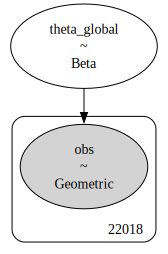

In [11]:
pm.model_to_graphviz(model_simple)

The returned samples are stored in an "inference data" object,
together with some extra informtation (e.g. the numer of chains and samples, infos about the sampling process, etc.).
It is rendered in a nice way in the notebook.
If you look inside the "posterior" branch, you can find the sampled variables there (here just `"theta_global"`).

In [12]:
idata_simple

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

We can have a look at the samples that were drawn using `arviz` plotting functions.
The left plot shows two lines because we have used two MCMC chains.
The right plot shows which values were drawn over time, so we can see if there are systematic differences
between early and late samples (that would be bad!).

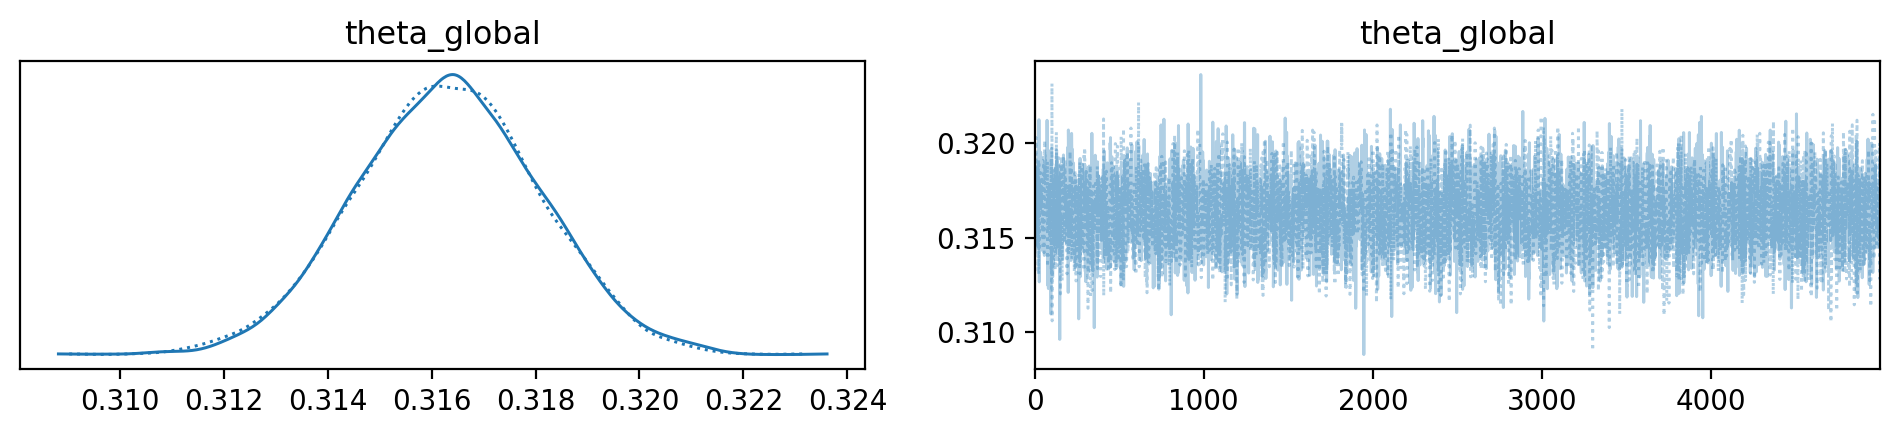

In [13]:
az.plot_trace(idata_simple);

This is another view of the posterior samples with some extra information.
As you can see, the "true" value of `theta` is probably close to 0.316 or 0.317,
but there is always a bit of uncertainty left (although it's not very large here).
We can obtain the precise expected value by just taking the mean of the samples,
but keep in mind that this is still only an estimate!

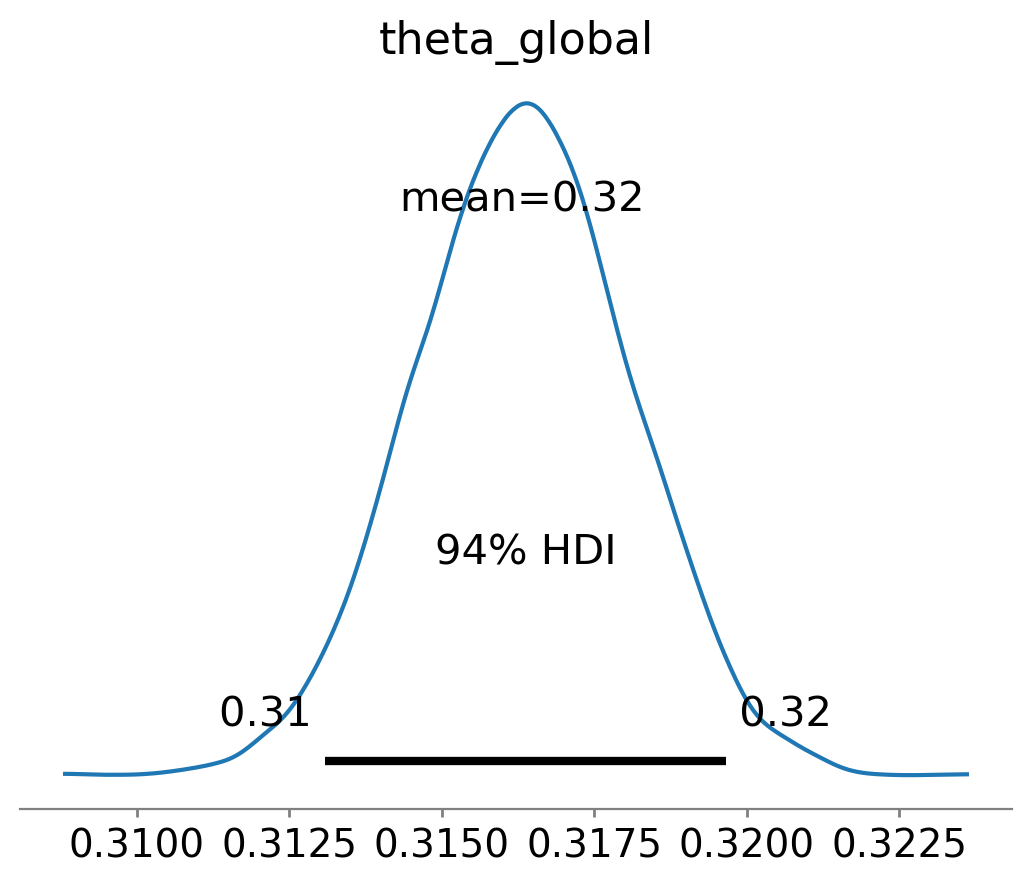

In [14]:
az.plot_posterior(idata_simple);

In [15]:
# expected value:
idata_simple.posterior["theta_global"].to_numpy().mean()

0.31631364574929194

# Model 2: one parameter per voice

The first model makes a lot of unrealistic assumptions about how interval sizes are determined.
Basically, the size of an interval is completely independent from where it occurs, in which voice,
or what happens around it, and all intervals follow the same distribution.

Let's try to make the model a bit less unrealistic.
What if the voice actually makes a difference?
Think of a model that would implement this idea and then implement the model below.
You can start with the simple model above and make some changes to it.

Here is a hint that might be useful:
The array `voice` above contains the voice of each note as a number between 0 and 3.
You can use these numbers as an index into another array that contains information for voices.
For example, if you want to translate the numbers into voice names,
you could create a 4-elemen array with these voice names and then use the `voice` array
to look up the voice name for each note:

In [16]:
voice_names = np.array(["soprano", "alto", "tenor", "bass"])
voice_names[voice]

array(['soprano', 'soprano', 'soprano', ..., 'bass', 'bass', 'bass'],
      dtype='<U7')

In [17]:
with pm.Model(coords={"voice": ["soprano", "alto", "tenor", "bass"]}) as model_voice:
    theta = pm.Beta("theta_voice", 0.5, 0.5, dims="voice")
    obs = pm.Geometric("obs", p=theta[voice], observed=observations+1) # +1 for geometric distribution (starts at 1, not 0)

    idata_voice = pm.sample(5_000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta_voice]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Let's have a look at the model architecture using `pm.model_to_graphviz()`.
Compare it to the simple model above.

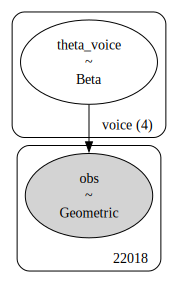

In [18]:
pm.model_to_graphviz(model_voice)

To get an idea of what happens in the model, plot the trace as before:

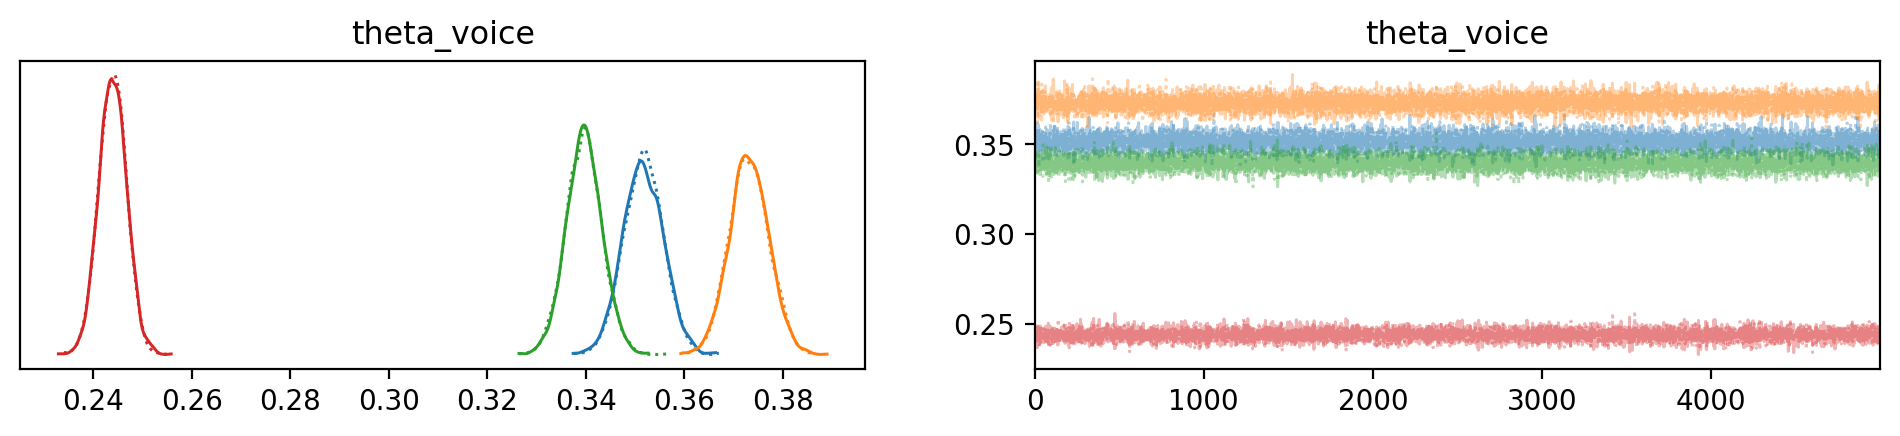

In [19]:
az.plot_trace(idata_voice);

Similarly, plot the posterior as before to see the results of inference:

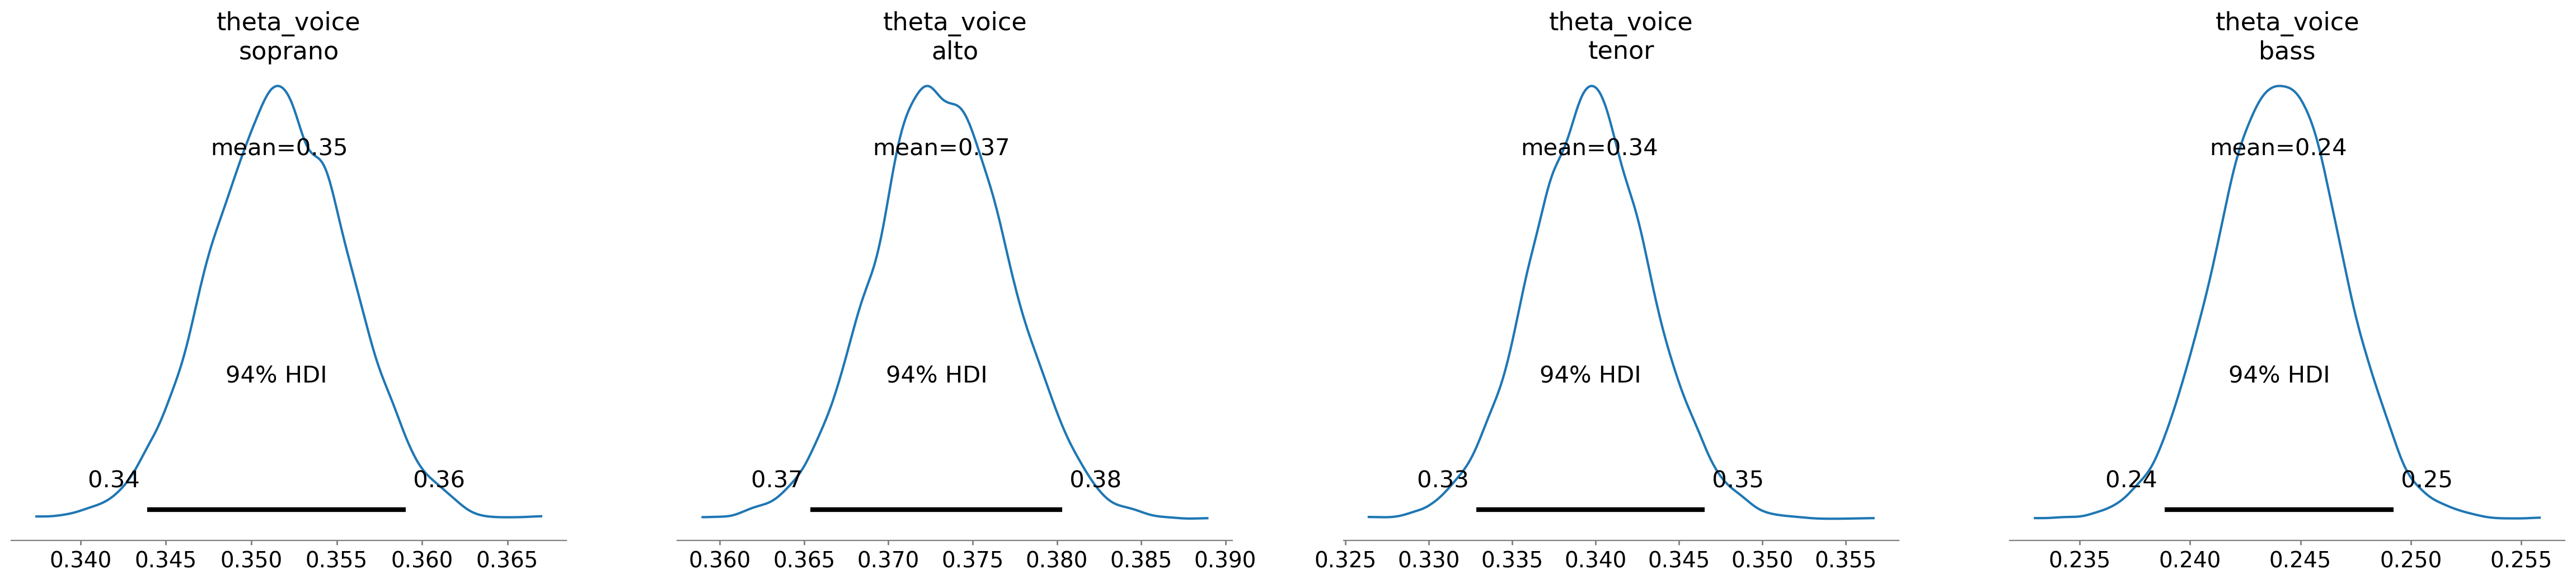

In [20]:
az.plot_posterior(idata_voice);

# Model 3: depend on register

So what if the size of the intervals doesn't actually depend on the voice but on the register that they appear in?
After all, vertical intervals tend to be larger in lower registers and smaller in higher registers too!
Let's first have a look at the data, to see, if that could make sense:

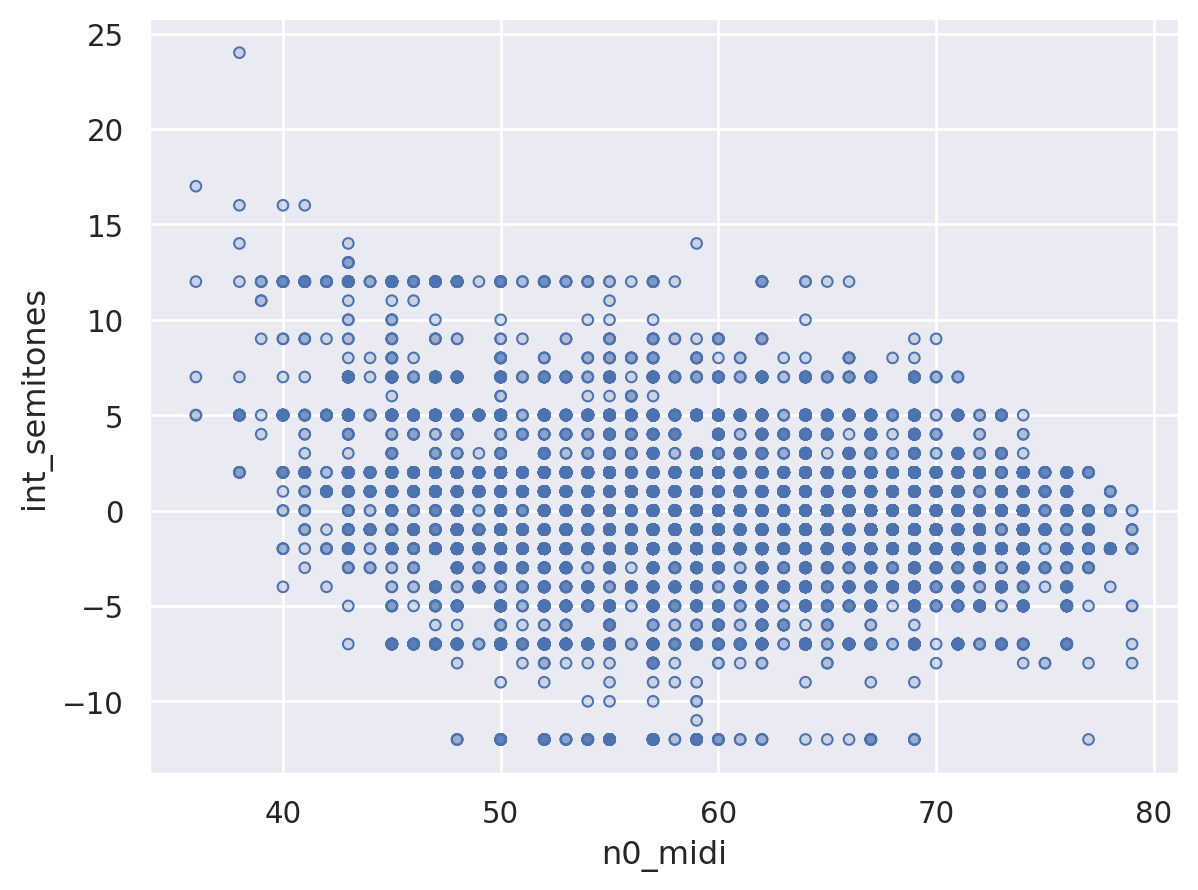

In [21]:
(
    so.Plot(dists, x="n0_midi", y="int_semitones").add(so.Dots())
)

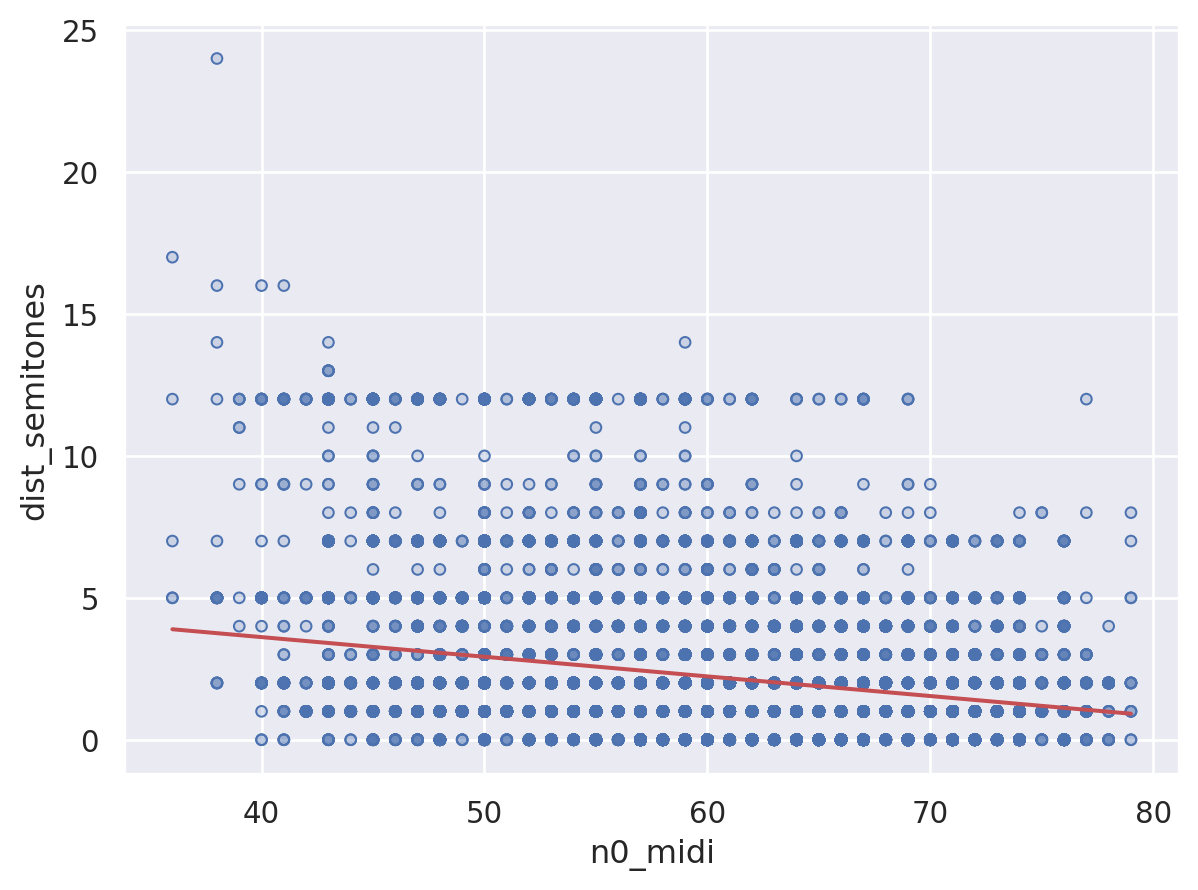

In [22]:
(
    so.Plot(dists, x="n0_midi", y="dist_semitones").add(so.Dots()).add(so.Line(color="r"), so.PolyFit(1))
)

In the second blot we see a slight tendency to get smaller intervals if the first note of the bigram is higher.
The added regression line seems to support that.
But is a linear regression really the right tool here?

Let's instead try to modify our model.
We keep the geometric distribution, but we make theta dependent on the pitch of the previous note ($p_0$).
In particular, we use a linear dependency between the pitch and the output:

$f(p_0) = a \cdot p_0 + b$

Then, we wrap the resulting value into a sigmoid function,
which is a curve with an S-shape that maps small values close to 0 and large value close to 1:

$\theta(p_0) = sigmoid(a \cdot p_0 + b) = \dfrac{1}{1+exp(-(a \cdot p_0 + b))}$

The parameter for the geometric distribution is then $\theta(p_0)$ for the current note.
Fortunately, we don't have to implement the sigmoid function ourselves
but can use `pm.math.sigmoid()`.

Try to implement this model as below.
You can find the preceding pitch of each note in the array `p0`.
Think about the parameters of this models. What values can they take? What could be suitable priors?

In [23]:
with pm.Model() as model_register:
    a = pm.Normal("a", 0, 10)
    b = pm.Normal("b", 0, 10)
    theta = pm.math.sigmoid(p0*a + b)
    obs = pm.Geometric("obs", p=theta, observed=observations+1)

    idata_register = pm.sample(5_000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 83 seconds.


It might be helpful to visualize the architecture of the model:

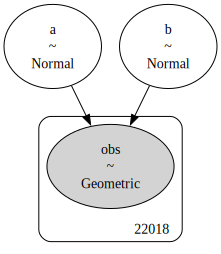

In [24]:
pm.model_to_graphviz(model_register)

Plot the trace:

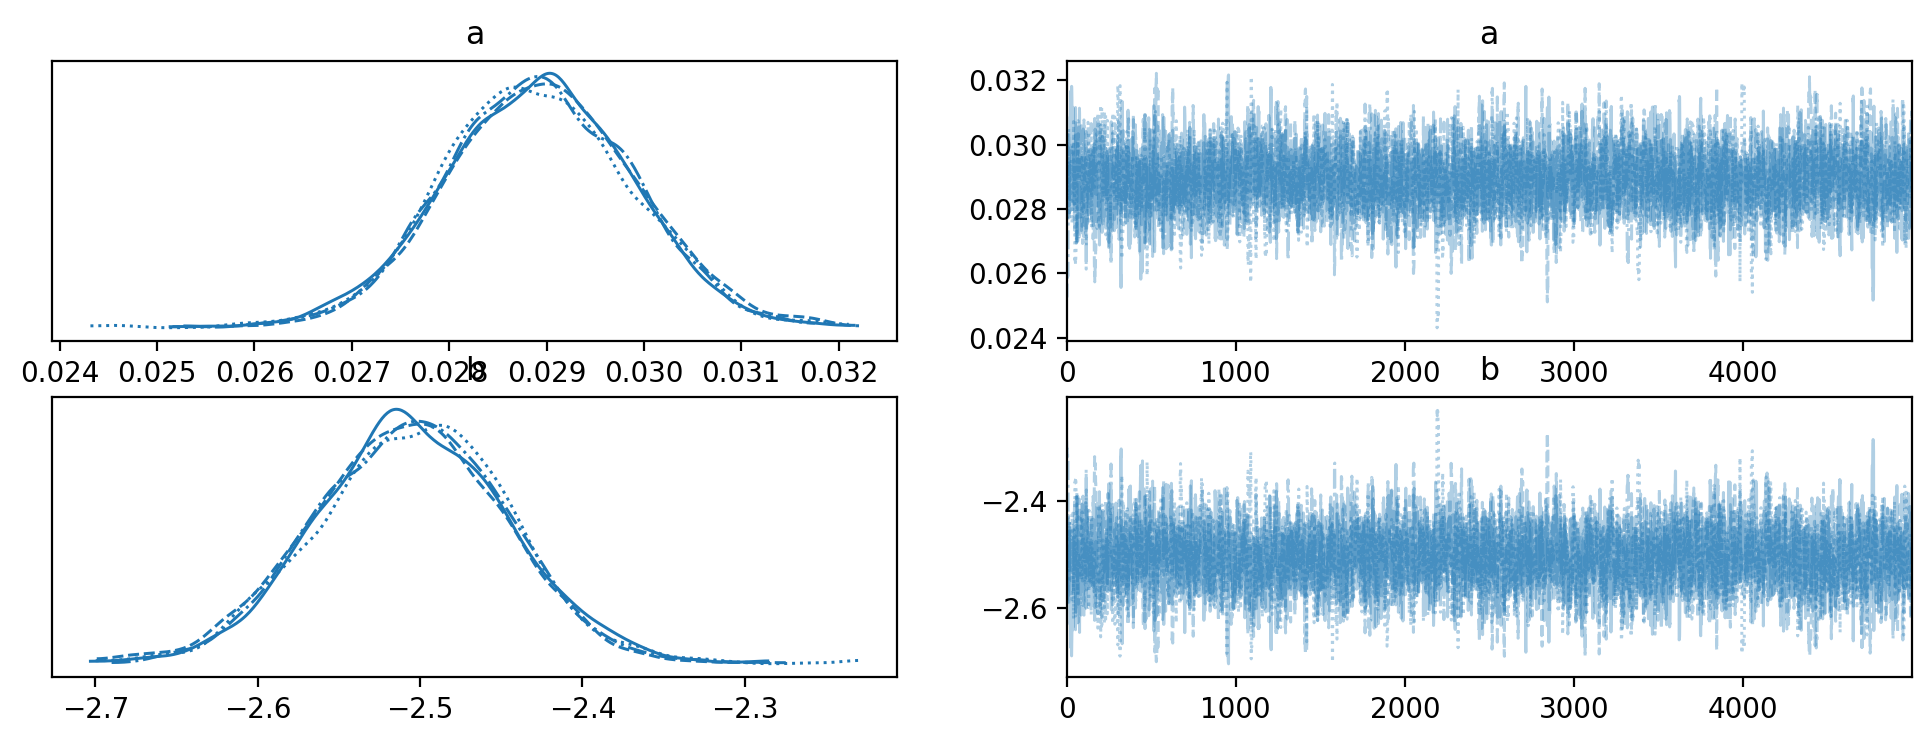

In [25]:
az.plot_trace(idata_register);

Plot the posterior:

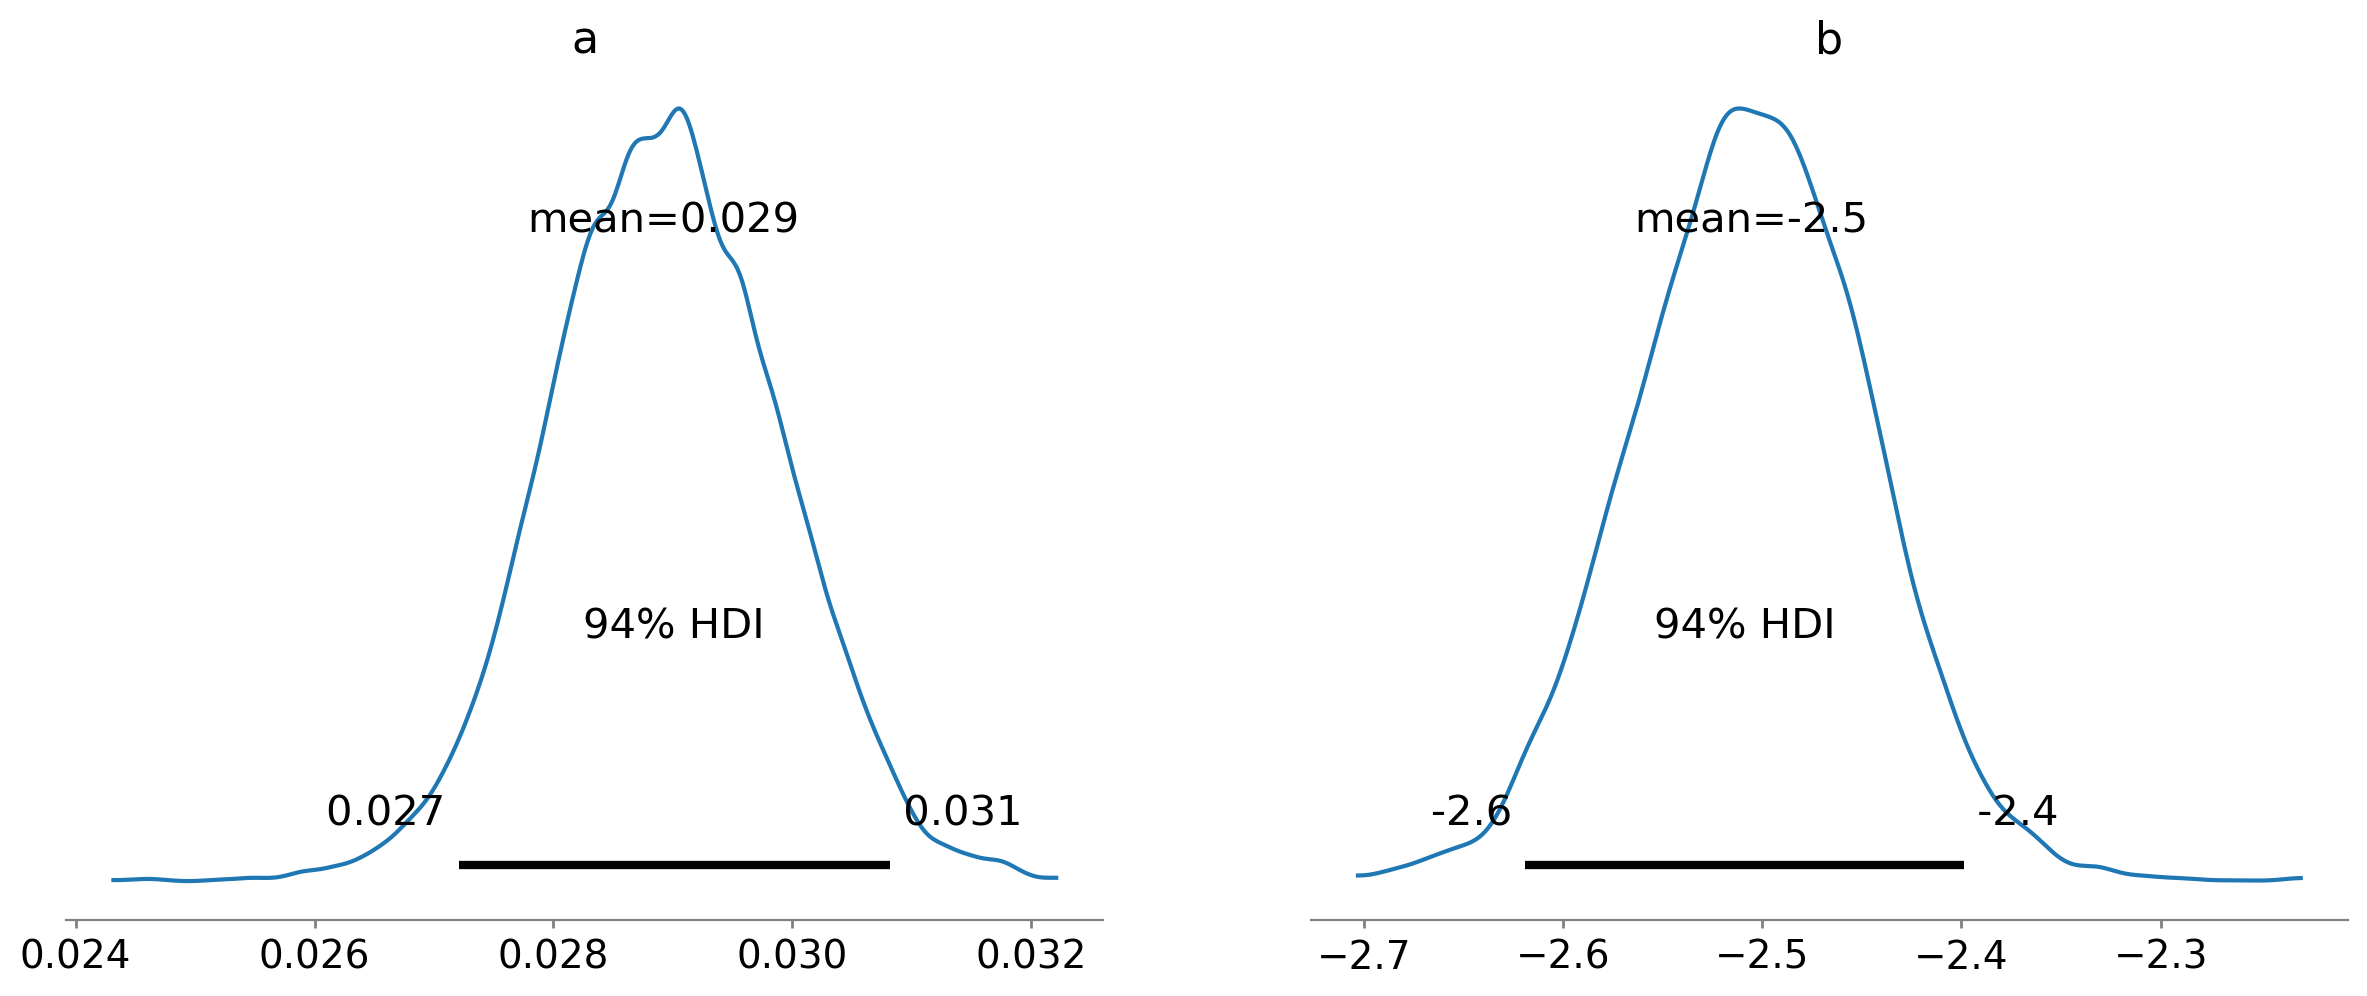

In [26]:
az.plot_posterior(idata_register);

The posterior samples show us that the slop of the function is positive, so $\theta$ becomes larger for higher registers.
But what exactly does that mean?
Let's first look at the resulting sigmoid shape of $\theta$ by using the expected values of $a$ and $b$:

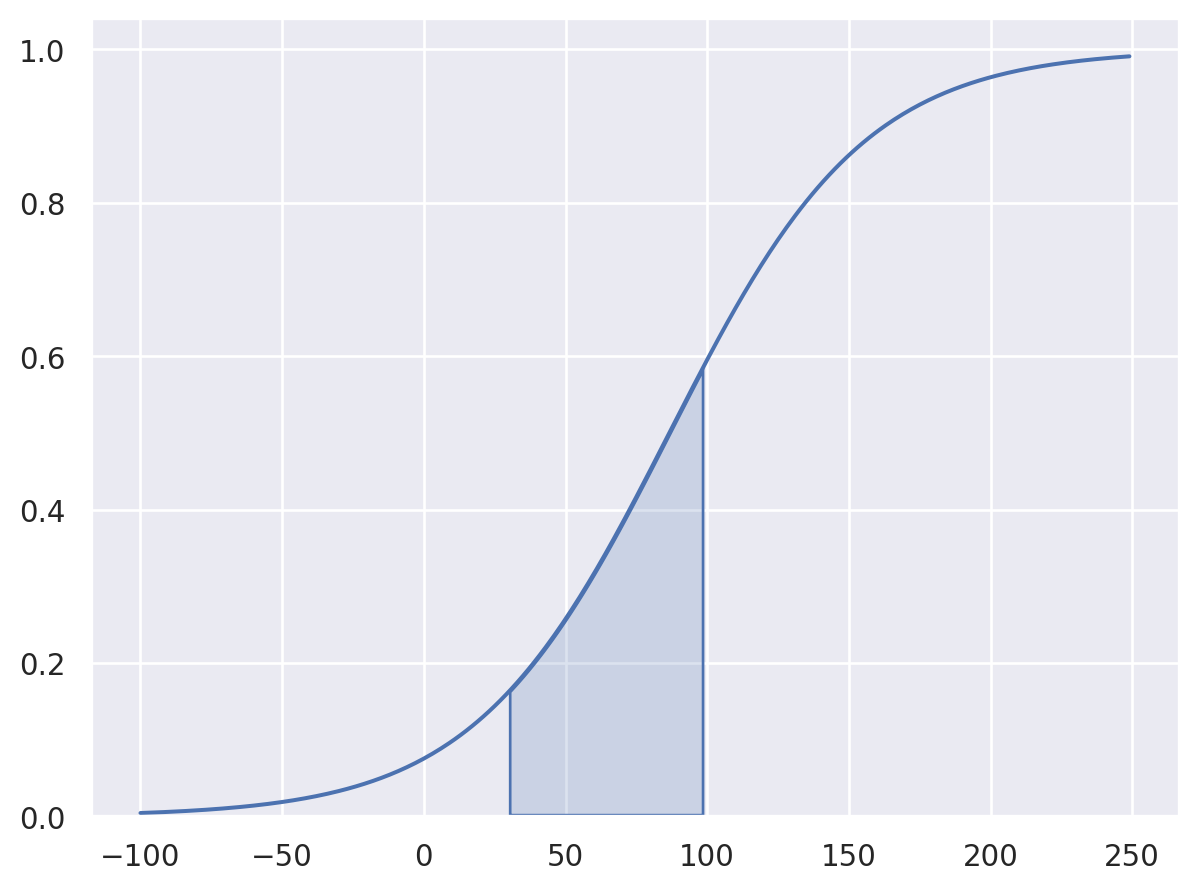

In [27]:
def plot_sigmoid(a, b):
    "This function plots a sigmoid curve for a given pair of model parameters a and b."
    x = np.arange(-100,250)
    # y = 1 / (1 + np.exp(-(a*x + b)))
    y = pm.math.sigmoid(x*a + b).eval()
    return so.Plot(x=x, y=y).add(so.Line()).add(so.Area(), x=x[130:200], y=y[130:200])

plot_sigmoid(idata_register.posterior["a"].mean().item(), idata_register.posterior["b"].mean().item())

So $\theta$ changes quite a bit from less than 0.2 for low pitches to almost 0.6 for the highest.
But we can't really see the uncertainty here, and it's still a bit difficult to imagine what that means for the intervals.
So let's look at the *expected interval size* in different registers,
and actually use the posterior samples to get an idea of how much this could vary:

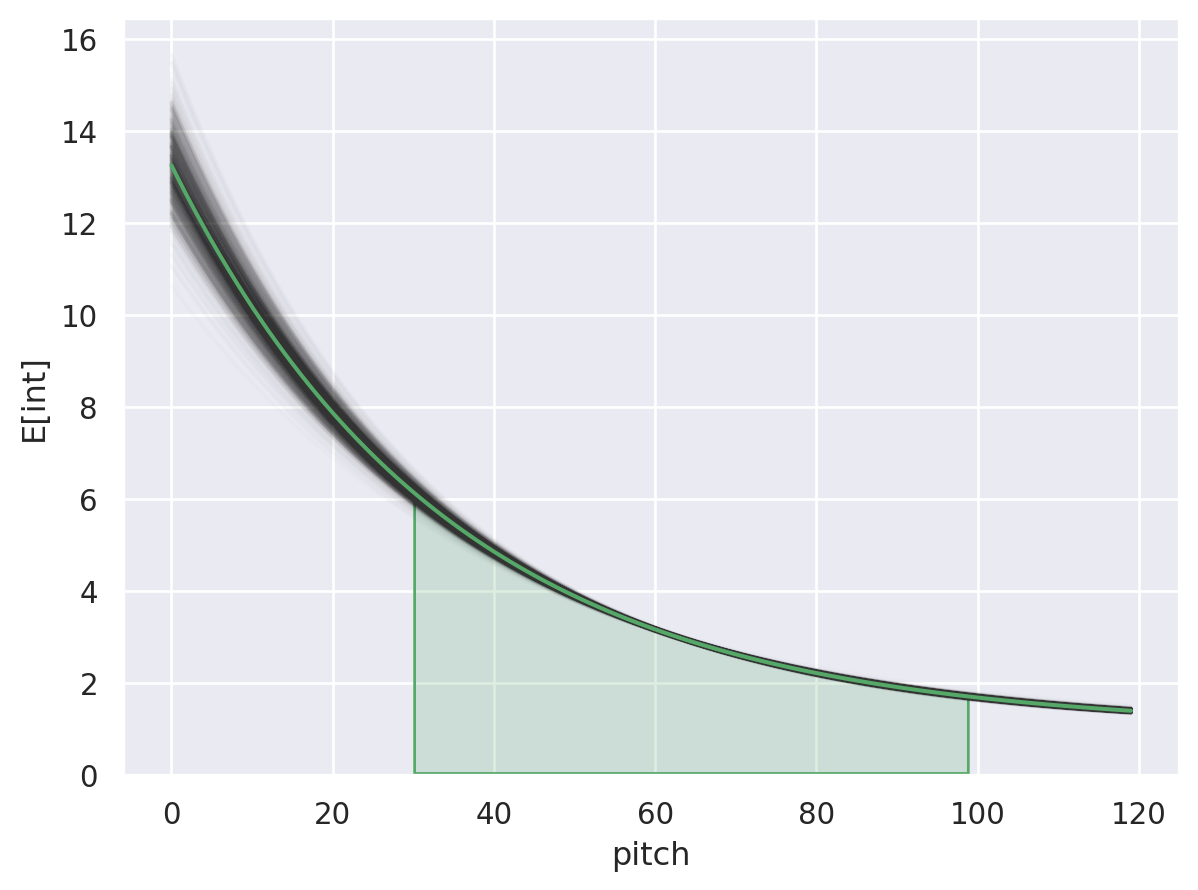

In [28]:
def plot_expected_sizes(a, b):
    """
    This function plots curves of the expected interval size given the preceding pitch
    for several pairs of model parameters.
    `a` contains all values for a, `b` contains all parameters for b,
    as found in the inference data.
    Also plots a curve for the mean value and highlights the range of pitches in the dataset.
    """
    # select some samples
    ny = 1_000
    indices = rng.choice(np.arange(a.size), ny, replace=False)

    # compute the sigmoids for the selected samples
    x = np.arange(0,120)
    y = (1 + np.exp(-(np.atleast_2d(a[indices]).T * np.atleast_2d(x) + np.atleast_2d(b[indices]).T)))

    # create a dataframe that holds the sample sigmoids, this makes it easier to plot with seaborn
    data = pd.DataFrame({
        "pitch": np.tile(x, ny),
        "E[int]": y.flatten(),
        "group": np.concatenate([np.full(x.size, iy) for iy in range(ny)])
    })
    
    # compute the sigmoid for the sample mean over all samples (same as previous plot)
    amean = a.mean()
    bmean = b.mean()
    ymean = (1 + np.exp(-(amean*x + bmean)))

    # create the plot with sample sigmoids and mean sigmoid
    return (
        so.Plot()
            .add(so.Line(alpha=0.01, color=".2"), data=data, x="pitch", y="E[int]", group="group")
            .add(so.Line(color="g"), x=x, y=ymean)
            .add(so.Area(color="g"), x=x[30:100], y=ymean[30:100])
    )

plot_expected_sizes(idata_register.posterior["a"].to_numpy().flatten(), idata_register.posterior["b"].to_numpy().flatten())

One thing that we can observe here is that the uncertainty is smallest in the center of our pitch range
because that is where we have most observations.
We don't have any observations outside the highlighted range, so it's only natural that the uncertainty increases there.

Another thing that follows from this shape is that $a$ and $b$ probably don't vary independently.
If $a$ is a bit flatter or steeper, then $b$ is adjusted accordingly to still go throught the middle of the data.
We can actually see this correlation if we plot the corresponding samples of $a$ and $b$ together:

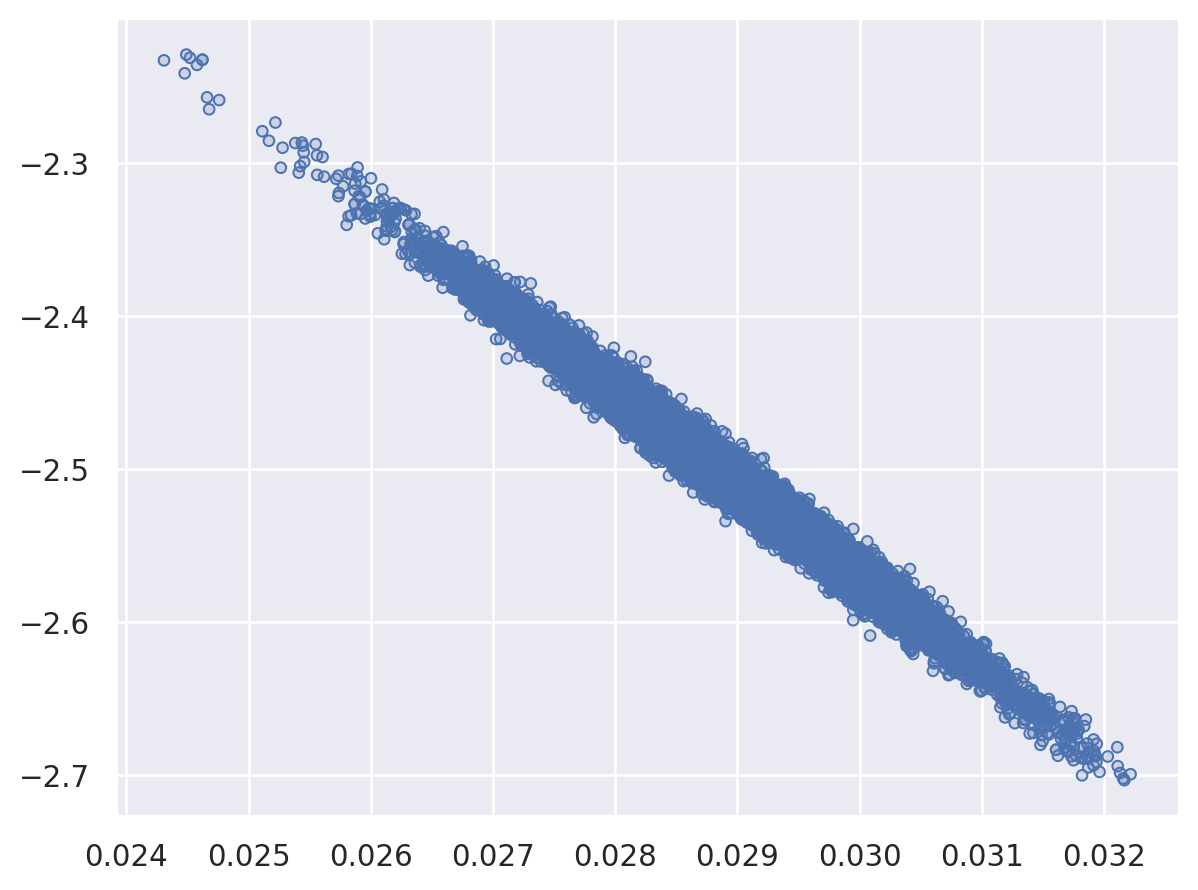

In [29]:
so.Plot(x=idata_register.posterior["a"].to_numpy().flatten(), y=idata_register.posterior["b"].to_numpy().flatten()).add(so.Dots())

# Checking the model: simulate data

So how good (or bad) are these models really?
There are several ways to check this but one very intuitive way is to do a "simulation"
and generate new data with our models.
If the models tell a good generative story about the dataset,
then they should also generate new data that looks somewhat like our observations.
With probabilistic programs, it is particularly easy to do this since they already have a generative form.
And probabilistic programming libraries provide special tools for sampling from the *posterior predictive* distribution,
i.e. the distribution of *new data* after observing old data:

$p(x' | \vec{x})$

In PyMC, we do this by taking our sample of posterior parameter values in the inference data.
For each set of parameter values in this sample, a new set of "observation" ($\vec{x'}$)
is sampled from the posterior predictive distribution.
Since our observations are already long arrays, we would normally get many more observations in total then we have originally
namely `n_obs * n_samples`.
However, we can also choose to generate fewer new points for each posterior sample, e.g. just one new $x'$ for each set of parameters.

## By Voice

We can reuse our per-voice model,
but in order to avoid sampling too many new observations,
we replace the data that is used in the model,
i.e., the observed intervals and the voices.

So far, the data is hardcoded in the model and can't be changed.
There are two ways to get around that:
Either create a second model, identcal to the first one but with different data,
or we change the model to use `pm.MutableData()` containers.
These containers are very simple: in the model definition,
you create a `MutableData` object that you give a name and the inital data that you want to use.
Here is an example:

In [30]:
with pm.Model() as example_model:
    # initialize the mutable data container
    some_data = pm.MutableData("name_of_data", [1,2,3,4,5])
    # use the data in the rest of the model, just like before
    pm.Binomial("obs", 10, 0.5, observed=some_data)
    # ...

In a second step, you can go back "into" the model using
```python
with example_model:
   ...
```
and then replace the data in the container using `pm.set_data()`.
This function takes a dictionary (`{"key": value, ...}`),
where the keys are the names for the data containers that you define in `pm.MutableData()`,
and the values are the new values for the respective containers:

In [31]:
with example_model:
    pm.set_data({"name_of_data": [6,7,8]})
    # ...

Rewrite the voice model from above to use a `MutableData` container
for both the observed intervals and the corresponding voices:

In [32]:
with pm.Model(coords={"voice": ["soprano", "alto", "tenor", "bass"]}) as model_voice:
    staff_ = pm.MutableData("data_voice", voice)
    obs_ = pm.MutableData("data_obs", observations+1)
    theta = pm.Beta("theta_voice", 0.5, 0.5, dims="voice")
    obs = pm.Geometric("obs", p=theta[staff_], observed=obs_)

    # use this, if you want to resample the data:
    # idata_voice = pm.sample(5_000, chains=2)

Now, let's modify the data in the original model so that we can use it for simulation.
Remember that sampling from the posterior already gave us a few thousand sets of parameter values.
For simulating new outputs of the model given these parameters,
it should be sufficient to only take each parameter set, and sample a few intervals per voice,
or maybe even just one.
To achieve this, we change the data inside the model.
Instead of huge data arrays with many examples of intervals in each voice,
we only use one entry per voice, so the `voice` array becomes `[0,1,2,3]`.
For `obs`, we just provide a dummy array like `[1,1,1,1]`
since we resample its values anyways.
(These values will be ignored, but we need to provide something to make the model happy.)
If we do this, we will get new intervals, one for each voice and for each set of parameters in the posterior sample.

Go back into your new version of the voice model (using `with`) and
- set the model data to the new values using `pm.set_data`;
- use `pm.sample_posterior_predictive(idata_voice, extend_inferencedata=True)` to generate new intervals.

You have to give the function `pm.sample_posterior_predictive` your inference data object that contains the posterior sample.
Adding the keyword `extend_inferencedata=True` will add the new samples to the old idata object instead of creating a new one.

In [33]:
with model_voice:
    pm.set_data({"data_voice": [0,1,2,3], "data_obs": [1, 1, 1, 1]})
    pm.sample_posterior_predictive(idata_voice, extend_inferencedata=True)

idata_voice

Sampling: [obs]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

Run the cell below to plot the simulation results compared to the original data:

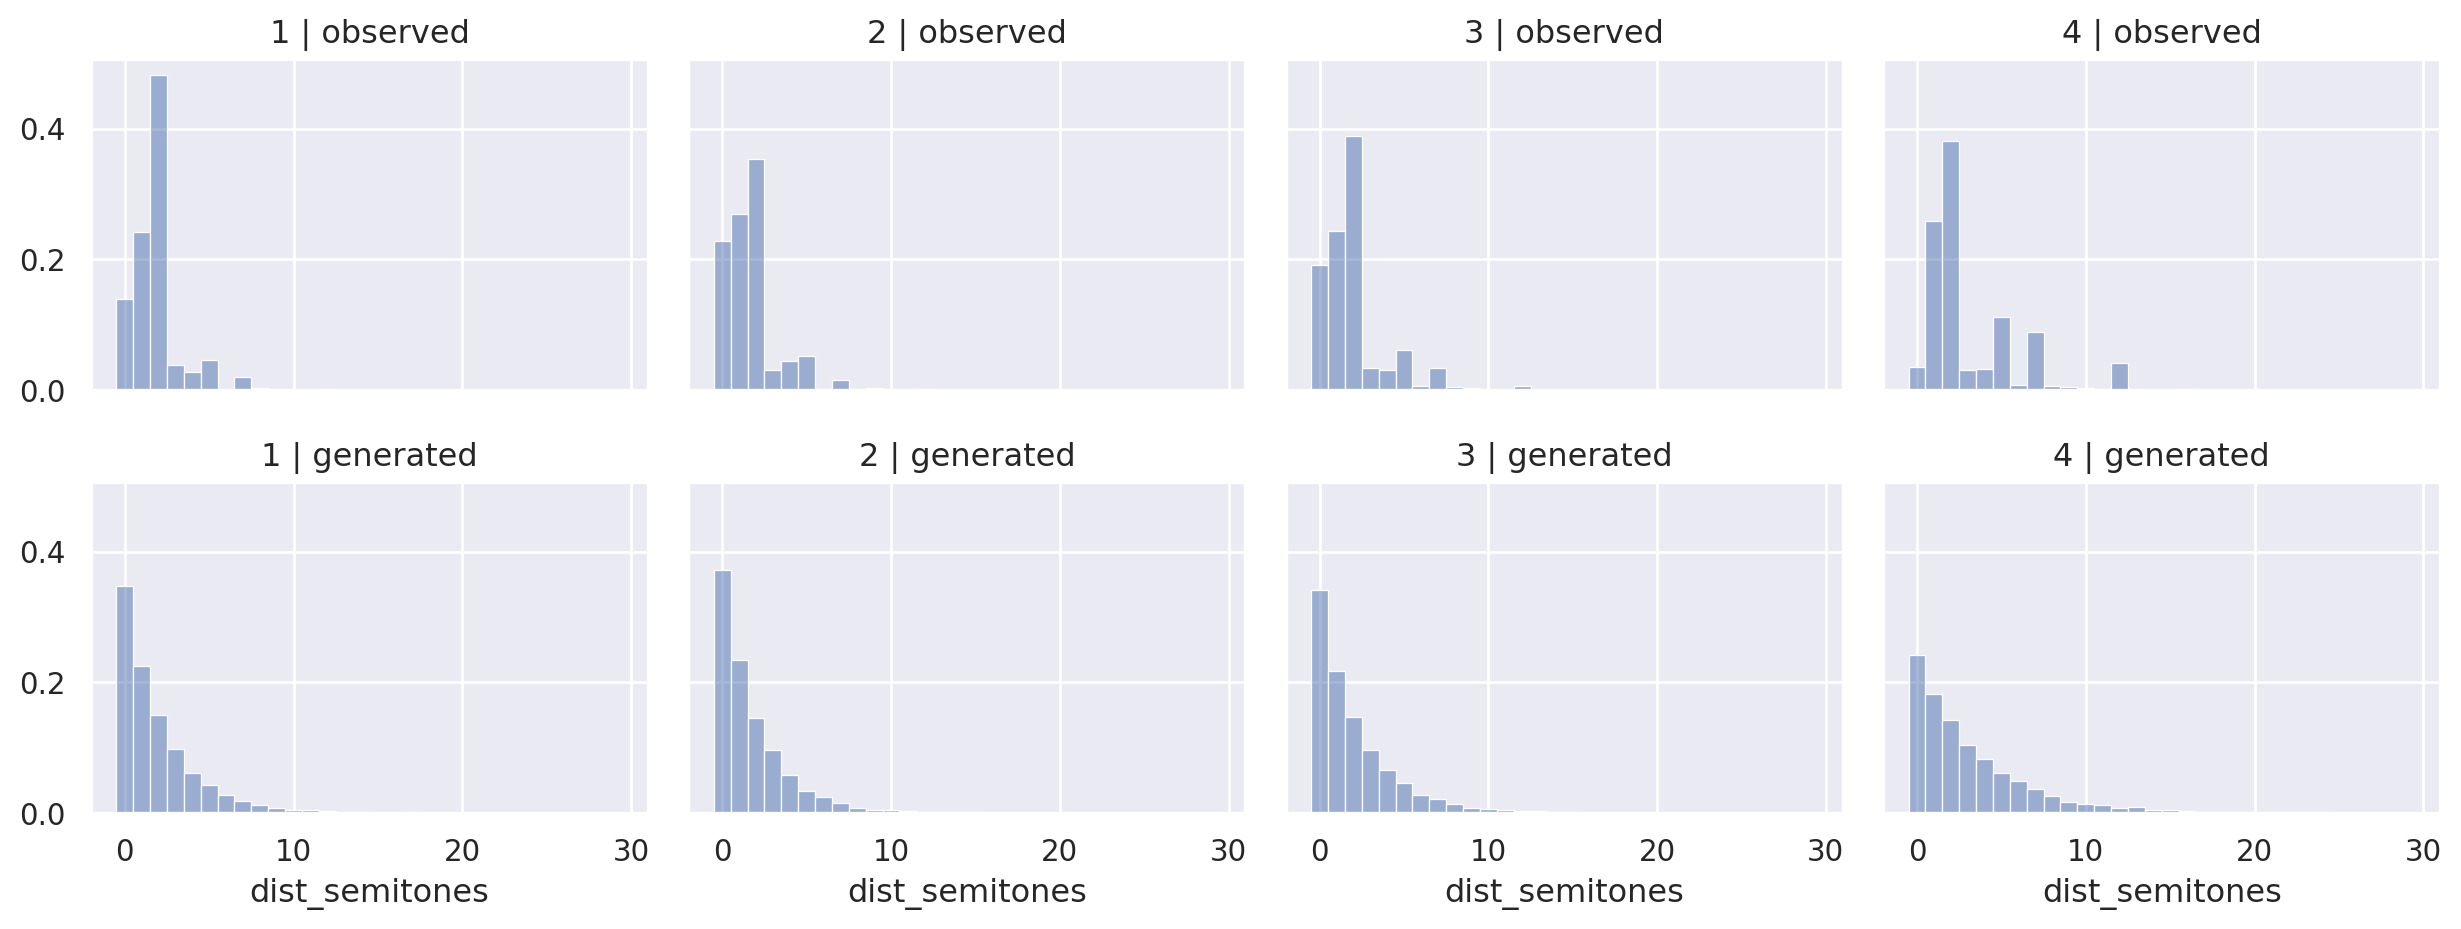

In [34]:
def plot_compare_voice(idata, original):
    """
    This function takes an idata object containing posterior predictive samples,
    as well as the dataframe containing the original data.

    It will plot histograms with the interval sizes for each voice and group (original vs generated).
    """
    gen_samples = idata.posterior_predictive["obs"].to_numpy().flatten()
    n_chains = idata.posterior_predictive.dims["chain"]
    n_draws = idata.posterior_predictive.dims["draw"]
    gen_df = pd.DataFrame({
        "staff": np.tile([1,2,3,4], n_chains * n_draws),
        "dist_semitones": gen_samples-1,
        #"bigram_id": np.repeat(np.arange(n_chains * n_draws), 4)
    })
    df_voice = pd.concat((original.reset_index(), gen_df),
                         join="inner",
                         keys=["observed", "generated"],
                         names=["source", "sample"])

    return (
        so.Plot(df_voice, x="dist_semitones")
            .facet(row="source", col="staff")
            .add(so.Bars(alpha=0.5), so.Hist("density", discrete=True))
            #.add(so.Line(), so.KDE())
            .layout(size=(13,5))
    )

plot_compare_voice(idata_voice, dists)

We can observe that the different $\theta$s for the different voices also correspond to different widths in the observed distributions,
so the model is able to reflect this aspect of the data.
On the other hand, there are still big differences between the observed distributions and the inferred ones.
For example, $0$ (unison) is usually way to common in the model compared to steps (1 or 2 semitones),
which is a problem of the geometric distribution.
Another aspect is that there seem to be "systematic outliers", e.g., some voices have little bumps at 5 (4th), 7 (5th) and 12 (octave).
A better model would probably take the special functions of steps as well as perfect intervals into account!

## By Register

For the register model, we use the same procedure as above,
but this time we draw one observation for each possible pitch $p_0$ at each posterior sample instead of each voice.
We compute the range of preceding pitches in the cell below:

In [35]:
p0_range = np.arange(p0.min(), p0.max()+1)
fake_obs_p0 = np.ones(p0_range.shape, dtype=int) # these are the fake observations

p0_range, fake_obs_p0

(array([36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
        53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
        70, 71, 72, 73, 74, 75, 76, 77, 78, 79]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

First, rewrite the register model to use `MutableData` containers for `p0` and `obs`:

In [36]:
with pm.Model() as model_register:
    p0_ = pm.MutableData("data_p0", p0)
    obs_ = pm.MutableData("data_obs", observations+1)
    a = pm.Normal("a", 0, 10)
    b = pm.Normal("b", 0, 10)
    theta = pm.math.sigmoid(p0_*a + b)
    obs = pm.Geometric("obs", p=theta, observed=obs_)

    # idata_register = pm.sample(5_000, chains=4)

Then, use this model, replace the original data with `p0_range` and `fake_obs_p0` (all 1s)
and sample new observations as before.

In [37]:
with model_register:
    pm.set_data({"data_p0": p0_range, "data_obs": fake_obs_p0})
    pm.sample_posterior_predictive(idata_register, extend_inferencedata=True)

idata_register

Sampling: [obs]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

Again, let's plot the results:

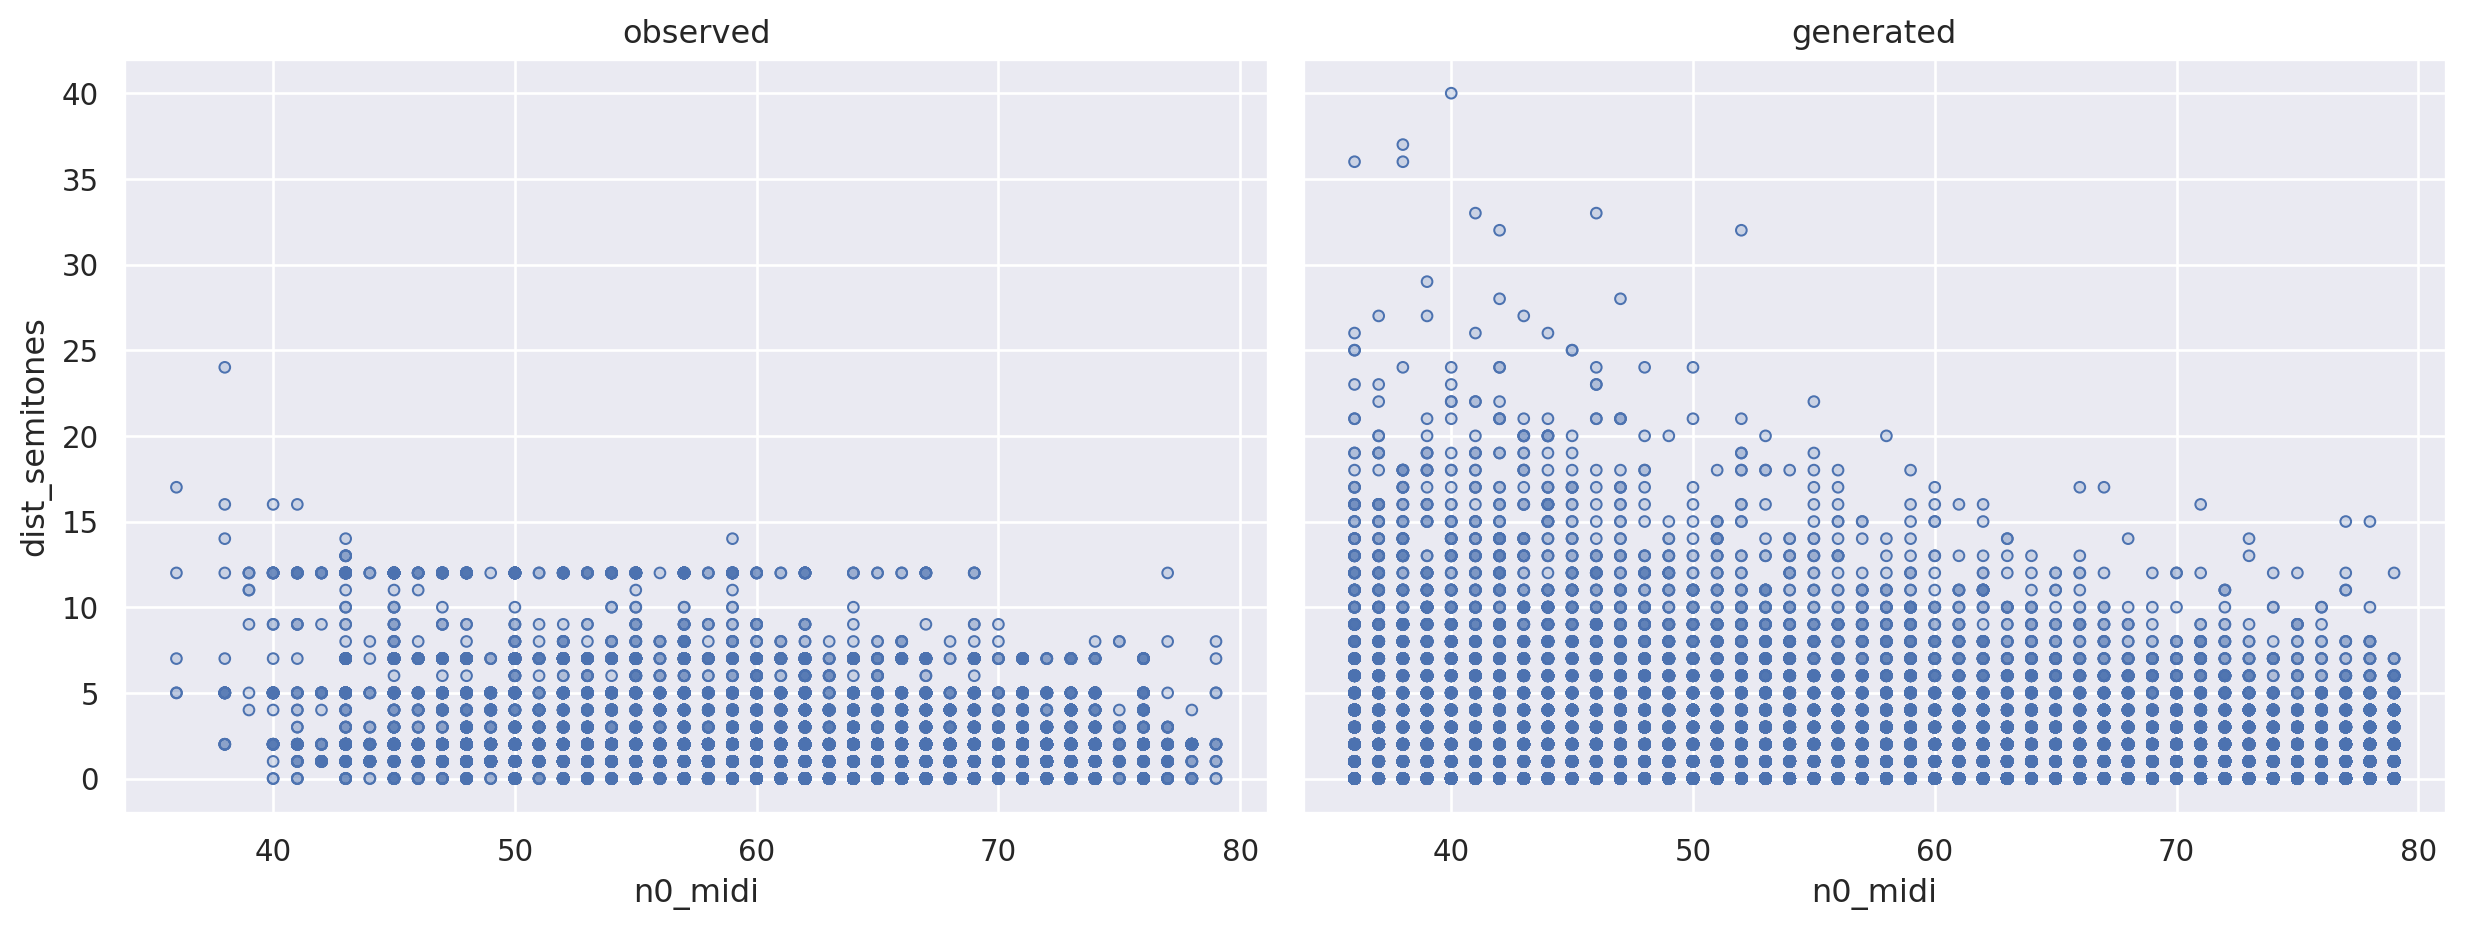

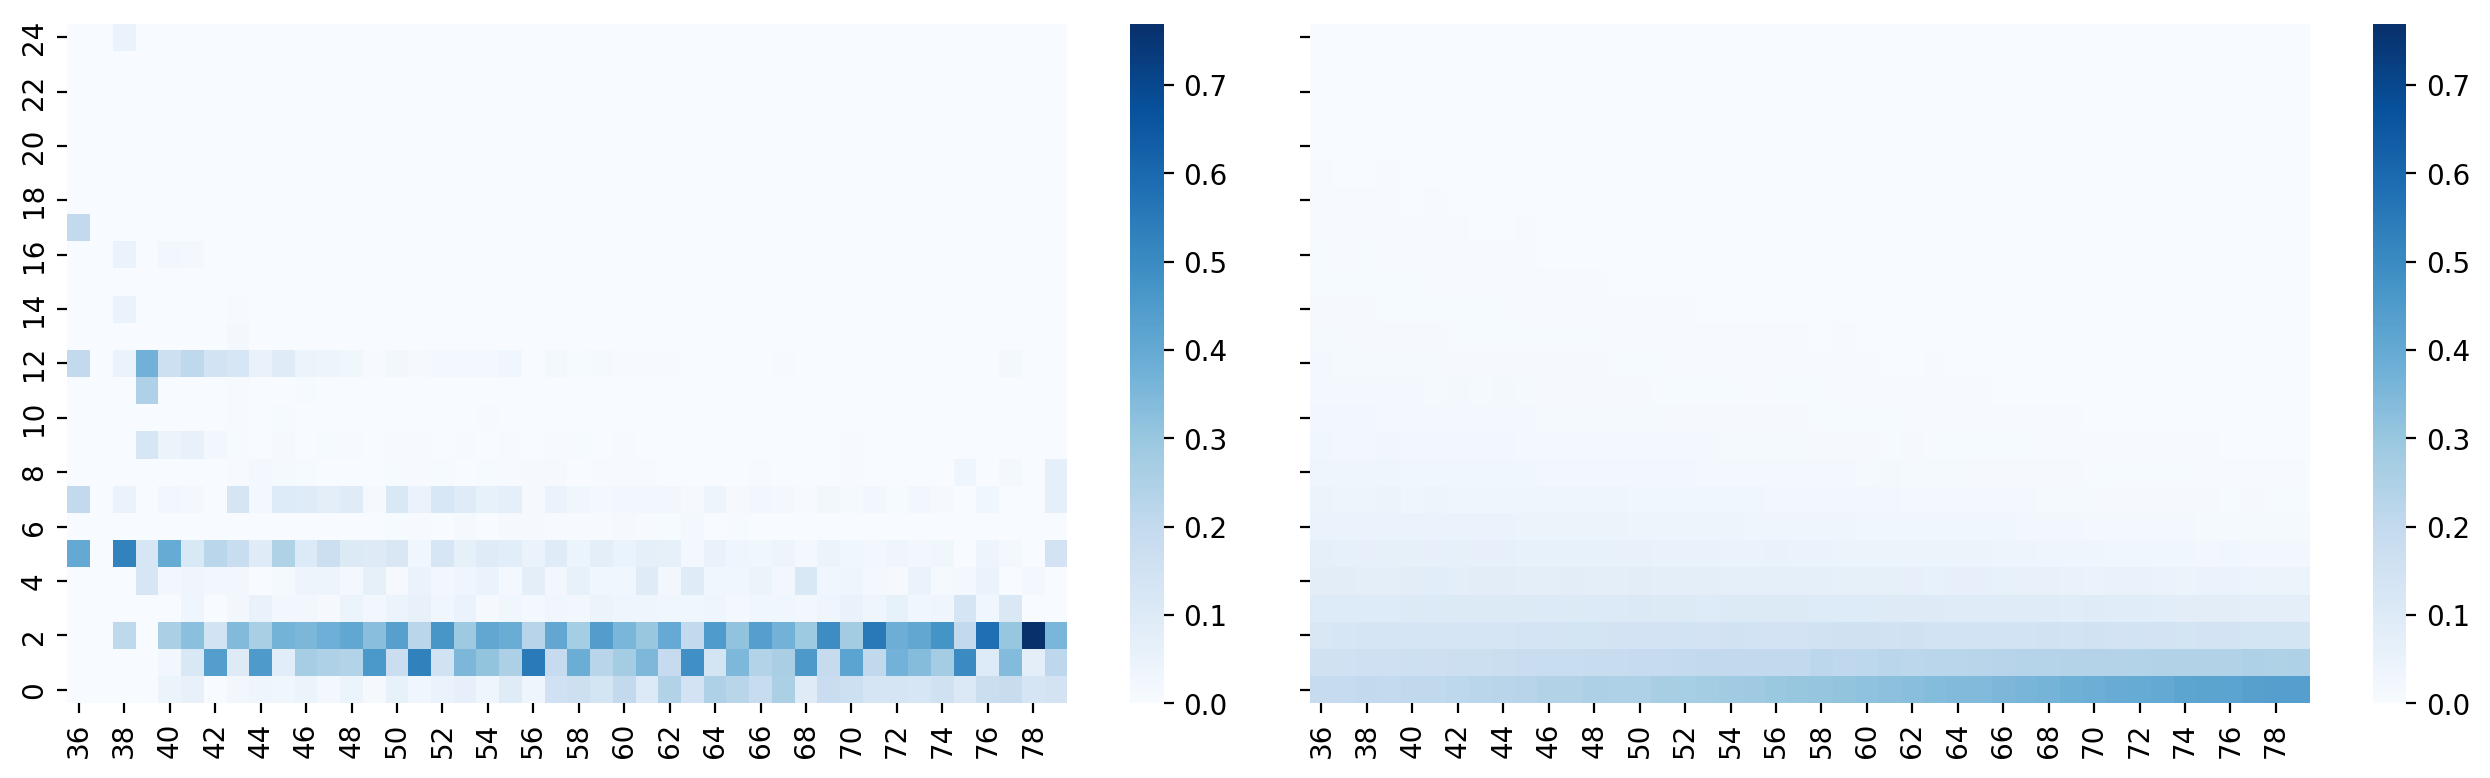

In [38]:
def plot_data_vs_generated(idata, original):
    """
    Plots histograms comparing simulated data from the register model
    to the original data.
    """
    gen_register = idata.posterior_predictive["obs"].to_numpy().flatten()
    n_chains = idata.posterior_predictive.dims["chain"]
    n_draws = idata.posterior_predictive.dims["draw"]
    gen_df = pd.DataFrame({
        "n0_midi": np.tile(p0_range, n_chains*n_draws),
        "dist_semitones": gen_register.flatten()-1,
        #"sample": np.repeat(np.arange(n_chains*n_draws), len(p0_range))
    })
    # combine dataframes, downsample generated to common size
    subsample = rng.choice(np.arange(len(p0_range)*n_chains*n_draws), len(original), replace=False)
    df = pd.concat([original.reset_index(), gen_df.iloc[subsample]], join="inner", keys=["observed", "generated"], names=["source", "sample"])

    def cond_hist(data):
        p0 = data.n0_midi
        dist = data.dist_semitones
        xmin, xmax = p0.min(), p0.max()
        ymin, ymax = dist.min(), min(24, dist.max())
        
        hist, xedges, yedges = np.histogram2d(p0, dist, range=[[xmin-0.5, xmax+0.5], [ymin-0.5, ymax+0.5]], bins=(xmax-xmin+1, ymax-ymin+1))
        marg = hist.sum(axis=1, keepdims=True)
        marg[marg==0] = 1
        hist_cond = hist / marg
        return pd.DataFrame(data=hist_cond.T, columns=np.arange(xmin, xmax+1), index=np.arange(ymin, ymax+1))
        
    def plot_hist(ax, df, vmax, cbar=True):
        sns.heatmap(df, ax=ax, cmap="Blues", vmin=0, vmax=vmax, cbar=cbar)

    hist_orig = cond_hist(original)
    hist_gen = cond_hist(gen_df)
    vmax = max(hist_orig.to_numpy().max(), hist_gen.to_numpy().max())
    
    fig, ax = plt.subplots(1, 2, figsize=(13,4), sharex=True, sharey=True)
    plot_hist(ax[0], hist_orig, vmax)
    plot_hist(ax[1], hist_gen, vmax)
    ax[0].invert_yaxis()
    fig.tight_layout()
    # return fig
    return so.Plot(df, x="n0_midi", y="dist_semitones").facet("source").add(so.Dots()).layout(size=(13,5))

plot_data_vs_generated(idata_register, dists)

We can make similar observations as above. The general tendency seems to be right,
but the model still doesn't capture a lot of the structure in the data, e.g. the bands at 5, 7, and 12.
In addition, there seems to be some "checkerboard" structure in the steps:
some pitches are followed by halftone steps, others by wholetones.
This could be caused by a bias in the keys that Bach uses, e.g. a preference for stem tones.
Generally, the original distribution is much more focussed on particular interval sizes than the relatively smooth model distribution.

(Note that the upper plot is a bit misleading about the variance of the given vs. the generated data.
We still have many more generated samples than given observations, so it's much more likely to sample larger intervals,
and the scatter plot isn't very good at showing that.
It's more apparent in the heatmap plot below, which is normalized by column, so each column shows the distribution $p(x|p_0)$.)